# EME Solver

This notebook demonstrates basic usage of Tidy3D's EigenMode Expansion (EME) solver. We simulate some example devices and discuss some tips and tricks.

EME is a frequency-domain method for propagating electromagnetic fields and computing the full bidirectional scattering matrix of a device along a fixed axis. It is useful for simulating longer waveguide devices; for such devices, it can be much faster than FDTD, although sometimes the results can be less accurate. EME is well-suited for devices in which the propagation is primarily confined to a particular axis. It is not well-suited for free-space or omnidirectional propagation. For example, in this notebook, we simulate an evanescent waveguide coupler and a waveguide taper, as shown below.

<img src="img/eme_evanescent_coupler.png" height="600" alt="Evanescent Waveguide Coupler">
<img src="img/eme_taper.png" height="600" alt="Waveguide Taper">

In a translationally invariant waveguide, the eigenmodes propagate independently, each with its own propagation constant. At a discontinuity in the transverse profile of a device, the forward and backward travelling modes on each side couple together; there is reflection and transmission described by a scattering matrix, expressed in the basis of eigenmodes on each side. The tangential fields are continuous at the interface. For a piecewise uniform device, we can calculate the scattering matrix at each discontinuity and then combine them to obtain the full scattering matrix. For a general device whose cross-sectional profile may vary continuously, we can discretize the device into cells into along the propagation axis, assuming that the cross section is uniform within each cell. If the discretization is fine enough, the resulting piecewise uniform geometry approaches the true continuously varying geometry.

In our EME solver, the simulation is divided into cells along the propagation axis. In each cell, we assume the device is translationally invariant and solve for the modes of the device. Between each pair of cells, the device cross section and modal basis can change; we impose field continuity conditions and solve for the coupling between the two modal bases.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from tidy3d.plugins import waveguide
import tidy3d.web as web

## Evanescent Waveguide Coupler

As a first example, we look at evanescent coupling between a pair of waveguides. Using EME, we can efficiently simulate long devices and perform length sweeps to help design these devices.

### EME Simulation Setup

We first define the materials and geometries present in the simulation.

In [2]:
si = td.material_library["cSi"]["Li1993_293K"]
sio2 = td.material_library["SiO2"]["Horiba"]

l = 6
h = 0.22
w = 0.45
g = 0.05

geo = td.GeometryGroup(
    geometries=[
        td.Box(size=(w, h, 2 * l), center=(-(w + g) / 2, 0, 0)),
        td.Box(size=(w, h, 2 * l), center=((w + g) / 2, 0, l)),
    ]
)

wvgs = td.Structure(geometry=geo, medium=si)

Now we define the EME simulation.

The EME simulation has a `grid_spec` field and an `eme_grid_spec` field. The `grid_spec` field defines a Yee grid like the one present in FDTD simulations. This grid is used for mode solving and for storing field data. In contrast, the `eme_grid_spec` defines a 1D grid along the propagation axis, dividing the simulation into EME cells. The choice of EME grid can be important in determining the speed and accuracy of the EME simulation. Here, we use an `EMEExplicitGrid` with three cells. We make sure that the cell boundaries are aligned with any discontinuities in the device profile, and we make sure that the number of modes in each cell is large enough to capture the physics of interest.

The EME solver always calculates the full bidirectional scattering matrix of the device. The scattering matrix is defined in the modal basis of the two ports of the device, which are the boundaries of the first and last EME cells. By default these would be the simulation bounds along the propagation axis; here, we set `port_offsets` to shift these boundaries. We also add an `EMEFieldMonitor` to help visualize the field.

Finally, we add a `sweep_spec` to the simulation in order to sweep the length of the coupling region. Simple length sweeps can be easier in EME simulations than in FDTD simulations -- the modes can be reused so there is no need to run a new simulation each time. The sweep settings are applied when calculating the scattering matrix, but have no effect on the `EMEFieldMonitor` or any other monitors.

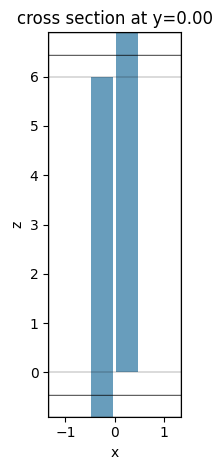

In [3]:
eme_grid_spec = td.EMEExplicitGrid(
    boundaries=[0, l],
    mode_specs=[
        td.EMEModeSpec(num_modes=2),
        td.EMEModeSpec(num_modes=4),
        td.EMEModeSpec(num_modes=2)
    ]
)

eme_field_mon = td.EMEFieldMonitor(
    name="field", 
    size=(td.inf, 0, td.inf)
)

lengths = np.linspace(l, 6*l, 100)

eme_sim = td.EMESimulation(
    center=(0, 0, l / 2),
    size=(6 * w, h + 4 * w, l + 4 * w),
    structures=[wvgs],
    medium=sio2,
    symmetry=(0, 1, 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=10),
    monitors=[eme_field_mon],
    eme_grid_spec=eme_grid_spec,
    freqs=[td.C_0 / 1.55],
    axis=2,
    port_offsets=(w, w),
    sweep_spec=td.EMELengthSweep(scale_factors=list(lengths / l))
)

_ = eme_sim.plot(y=0, monitor_alpha=0)
plt.show()

Now we run the simulation.

In [4]:
eme_sim_data = web.run(eme_sim, task_name="EME evanescent coupler")

12:20:09 UTC Created task 'EME evanescent coupler' with task_id                 
             'eme-81eecbf2-07ea-44f5-8bc9-58ca0fab43d2' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

Output()

12:20:11 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:20:23 UTC Maximum FlexCredit cost: 0.027. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:20:48 UTC status = success

Output()

12:20:49 UTC loading simulation from simulation_data.hdf5

             WARNING: updating EMESimulation from 2.7.2 to 2.7.3                

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

### EME Simulation Results

We can visualize the field data recorded by the field monitor. The field data is indexed by `eme_port_index` and `mode_index` in order to specify which port and which mode are excited.

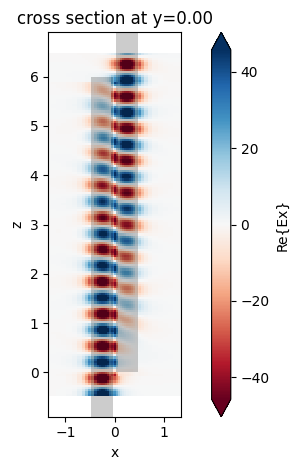

In [5]:
eme_sim_data.plot_field("field", "Ex", eme_port_index=0, mode_index=0)
plt.show()

We can plot the transmission as a function of the length of the coupling region.

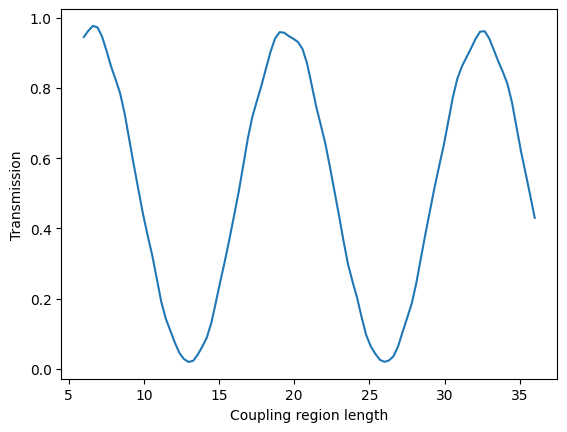

In [6]:
transmission = eme_sim_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0, f=0).abs**2
plt.plot(lengths, transmission)
plt.xlabel('Coupling region length')
plt.ylabel('Transmission')
plt.show()

## Taper Edge Coupler

Next, we look at a taper edge coupler. Using the Tidy3D EME solver, we are able to simulate long tapers and perform length sweeps. See also this [notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/EdgeCoupler.html) where this taper and some variants are optimized using FDTD. The function to create the taper geometry is based on the work of [G. Ren et al. (2013)](https://www.sciencedirect.com/science/article/abs/pii/S0030401811006389)

### EME Simulation Setup

First, we define the materials and geometries.

In [7]:
wl_c = 1.55  # Central wavelength.
freq0 = td.C_0 / wl_c

mat_si = td.Medium(permittivity=3.48**2)  # Taper and substrate material.
mat_sio2 = td.Medium(permittivity=1.44**2)  # Box and cladding material.
mat_air = td.Medium(permittivity=1.00)  # External medium material.

taper_l = 5  # Taper length.
taper_w_in = 0.19  # Taper tip width.
taper_w_out = 0.50  # Taper output width.
taper_t = 0.22  # Taper thickness.

box_thick = 3.0  # Silicon dioxide box layer.
clad_thick = 3.0  # Silicon dioxide layer covering the taper.

# Extra space around the taper at x,y directions.
pad_x = 1 * wl_c
pad_y = 1.5 * wl_c

# Large number to be used in replacement of td.inf when necessary.
_inf = 1e3

def get_taper(
    taper_shape="linear",
    init_coord=[pad_x, taper_w_in / 2],
    end_coord=[pad_x + taper_l, taper_w_out / 2],
):
    """Return a polygon composed of the taper vertices given the desired shape."""

    x0 = init_coord[0]
    x1 = end_coord[0]
    y0 = init_coord[1]
    y1 = end_coord[1]
    x = np.linspace(x0, x1, 41)

    tap_name = "linear_tap"
    if taper_shape == "quadratic":
        alpha = ((x - x0) / (x1 - x0)) ** 2
        tap_name = "quadratic_tap"
    elif taper_shape == "exponential":
        alpha = np.expm1((x - x0) / (x1 - x0)) / np.expm1(1)
        tap_name = "exponential_tap"
    elif taper_shape == "linear":
        alpha = (x - x0) / (x1 - x0)
    else:
        print(
            "taper_shape is neither 'linear', 'quadratic', or 'exponential'!\n"
            + "Linear taper shape returned!"
        )
        alpha = (x - x0) / (x1 - x0)

    y = y0 + alpha * (y1 - y0)
    upper_bound = [[xv, yv] for xv, yv in zip(x, y)] + [[_inf, y1]]
    lower_bound = [[_inf, -y1]] + [[xv, -yv] for xv, yv in zip(x[::-1], y[::-1])]
    taper_polygon = upper_bound + lower_bound

    # Inverted taper structure using a PolySlab.
    taper = td.Structure(
        geometry=td.PolySlab(
            vertices=taper_polygon, axis=2, slab_bounds=(-taper_t / 2, taper_t / 2)
        ),
        medium=mat_si,
        name=tap_name,
    )
    return taper

size_x = taper_l + 2 * pad_x
size_y = taper_w_out + 2 * pad_y
size_z = box_thick + clad_thick + taper_t

# Silicon dioxide box + cladding layers
sio2_medium = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(pad_x, -_inf, -_inf), rmax=(_inf, _inf, _inf)
    ),
    medium=mat_sio2,
)

# Simulation definition
taper_poly = get_taper(
    "linear",
    init_coord=[pad_x, taper_w_in / 2],
    end_coord=[size_x - pad_x, taper_w_out / 2],
)

Now we define the `eme_grid_spec` and `EMESimulation`. We use an `EMEUniformGrid`. It is important to use enough cells that the device profile does not change much in between each pair of cells. It can be necessary to experiment with different EME grids in order to make sure enough cells are used.

We set `store_port_modes=False` in the `EMESimulation` and `num_modes=1` in the `EMEFieldMonitor` to avoid downloading unnecessary data. We also add an `EMEModeSolverMonitor` and an `EMECoefficientMonitor` to help understand the simulation results.

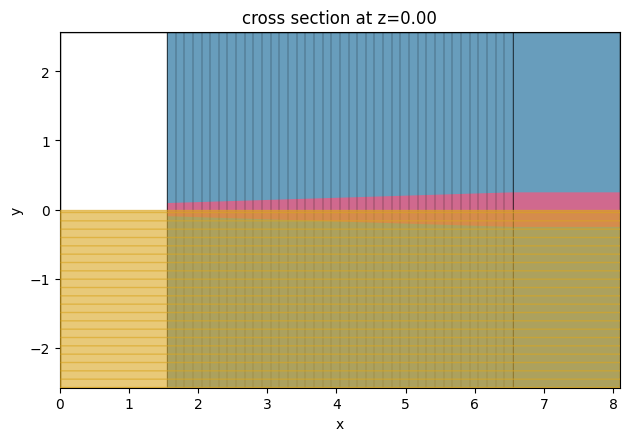

In [8]:
eme_num_modes = 30

eme_grid_spec = td.EMEUniformGrid(
    num_cells=40,
    mode_spec=td.EMEModeSpec(num_modes=eme_num_modes)
)

eme_field_mon = td.EMEFieldMonitor(
    name="field", 
    size=(td.inf, td.inf, 0),
    num_modes=1
)

eme_mode_mon = td.EMEModeSolverMonitor(
    name="modes", 
    size=(td.inf, td.inf, td.inf),
    center=(pad_x, 0, 0),
    num_modes=9,
    eme_cell_interval_space=40
)

eme_coeff_mon = td.EMECoefficientMonitor(
    name="coeffs", 
    size=(td.inf, td.inf, td.inf),
)

lengths = np.linspace(1, 100, 30)

eme_sim = td.EMESimulation(
    center=(size_x / 2, 0, 0),
    size=(size_x, size_y, size_z),
    medium=mat_air,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=wl_c),
    structures=[sio2_medium, taper_poly],
    monitors=[eme_field_mon, eme_mode_mon, eme_coeff_mon],
    symmetry=(0, -1, 1),
    axis=0,
    freqs=[freq0],
    eme_grid_spec=eme_grid_spec,
    port_offsets=(pad_x, pad_x),
    store_port_modes=False,
    sweep_spec=td.EMELengthSweep(scale_factors=list(lengths / taper_l))
)

eme_sim.plot(z=0, monitor_alpha=0)
plt.show()

In [9]:
eme_sim_data = web.run(eme_sim, task_name="EME taper")

12:20:52 UTC Created task 'EME taper' with task_id                              
             'eme-3fbf24fa-5e83-45fd-ade5-113766ff6aba' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

Output()

12:20:54 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:20:58 UTC Maximum FlexCredit cost: 0.476. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

Output()

12:23:15 UTC status = success

Output()

12:23:17 UTC loading simulation from simulation_data.hdf5

             WARNING: updating EMESimulation from 2.7.2 to 2.7.3                

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

We can plot the field to check that the results are sensible.

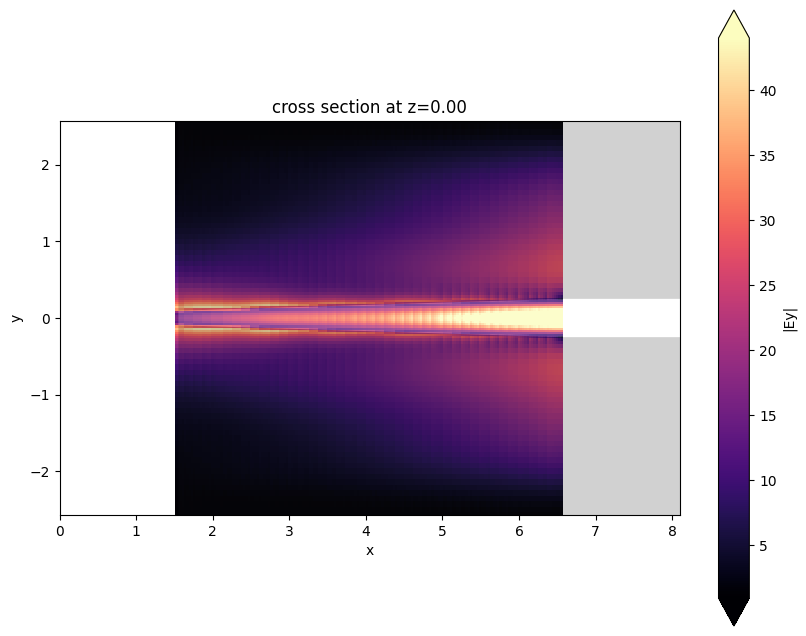

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
eme_sim_data.plot_field("field", "Ey", val="abs", eme_port_index=0, mode_index=0, ax=ax)
plt.show()

Now we plot the efficiency as a function of the taper length.

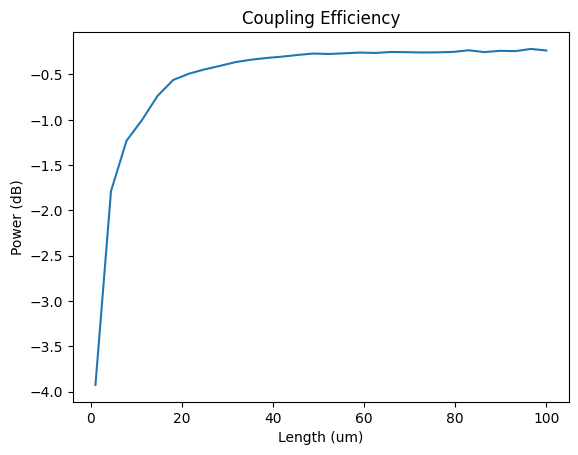

In [11]:
eff = 20 * np.log10((eme_sim_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0)).abs.squeeze())
plt.plot(lengths, eff)
plt.xlabel("Length (um)")
plt.ylabel("Power (dB)")
plt.title("Coupling Efficiency")
plt.show()

We can inspect the EME modes, for example at the input port. We see that only one is guided. The remaining modes still contribute to EME propagation, capturing radiative losses and other effects.

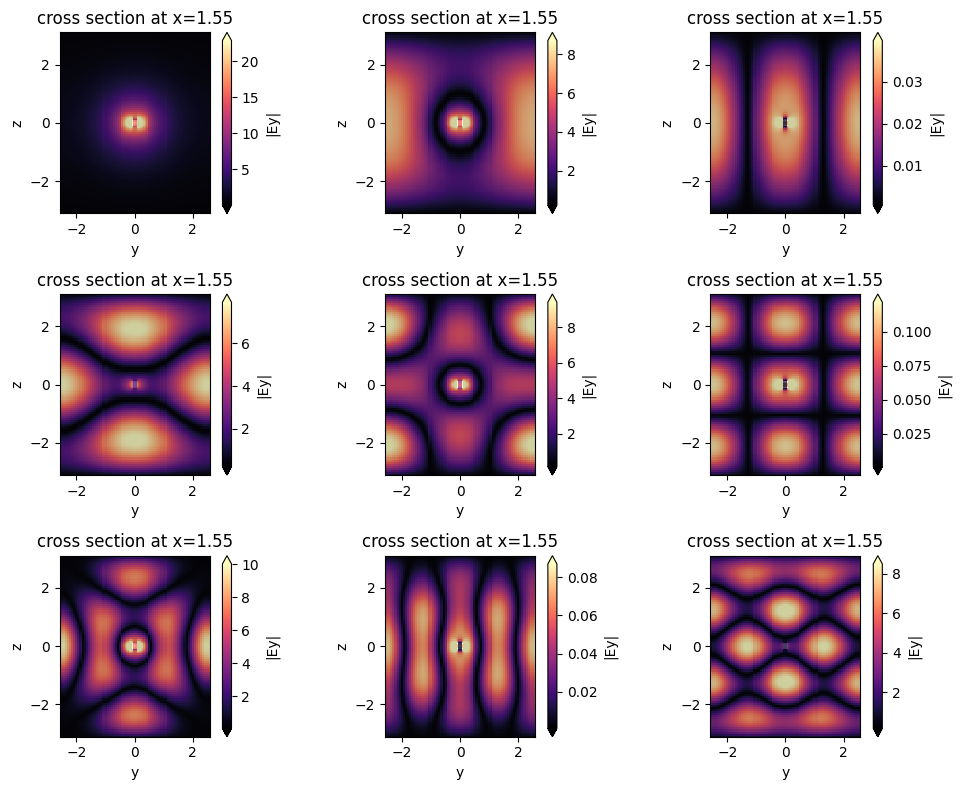

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(10, 8))
for mode_index in range(9):
    i = mode_index // 3
    j = mode_index % 3
    eme_sim_data.plot_field("modes", "Ey", val="abs", eme_cell_index=0, mode_index=mode_index, ax=ax[i][j])
plt.tight_layout()
plt.show()

We can also make a 2D plot of the scattering matrix as a function of cell index and mode index. This shows us that the scattering is occuring towards the beginning of the taper.

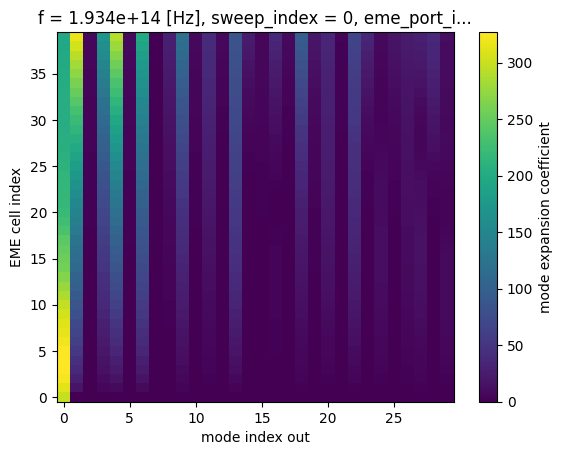

In [13]:
eme_sim_data["coeffs"].A.sel(mode_index_in=0, eme_port_index=0).abs.plot()
plt.show()

## Tips and Tricks

### Other Bases

By default, the scattering matrix is expressed in the basis of EME modes at the two ports. It is sometimes useful to use alternative bases. For example, in a waveguide splitter, we might want the scattering matrix in the basis of modes of the individual waveguides. The functions `EMESimulationData.smatrix_in_basis` and `EMESimulationData.field_in_basis` can be used for this purpose after the simulation has been run.

### Frequency Sweeps

Frequency sweeps are supported by including multiple frequencies in the `freqs` field. However, our EME solver repeats the mode solving for each new frequency, so frequency sweeps involving a large number of frequencies can be slow and expensive. If a large number of frequencies are required, consider using our FDTD solver instead.

### Passivity and Unitarity Constraints

Passivity and unitarity constraints can be imposed via the `constraint` field. These constraints are imposed at interfaces between cells, possibly at the expense of field continuity. Passivity means that the interface can only dissipate energy, and unitarity means the interface will conserve energy (energy may still be dissipated inside cells when the propagation constant is complex). Adding constraints can slow down the simulation significantly, especially for a large number of modes (more than 30 or 40).

### Too Many Modes

It is important to use enough modes to capture the physics of the device and to ensure that the results have converged (see below). However, using too many modes can slow down the simulation and result in numerical issues. If too many modes are used, it is common to see a warning about invalid modes in the simulation log. While these modes are not included in the EME propagation, this can indicate some other issue with the setup, especially if the results have not converged. In this case, extending the simulation size in the transverse directions and increasing the grid resolution may help by creating more valid modes that can be used in convergence testing.

### Mode Convergence Sweeps

It is a good idea to check that the number of modes is large enough by running a mode convergence sweep. Here, we check convergence in the previous taper example.

In [14]:
sweep_spec = td.EMEModeSweep(num_modes=list(np.arange(1, eme_num_modes)))

eme_sim = eme_sim.updated_copy(
    sweep_spec=sweep_spec,
    monitors=[]
)

In [15]:
eme_sim_data = web.run(eme_sim, task_name="EME taper convergence sweep")

12:23:27 UTC Created task 'EME taper convergence sweep' with task_id            
             'eme-6c04518b-c035-4ab8-8aea-e0be1f74101d' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

Output()

12:23:29 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:23:32 UTC Maximum FlexCredit cost: 0.466. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:24:32 UTC status = success

Output()

12:24:35 UTC loading simulation from simulation_data.hdf5

             WARNING: updating EMESimulation from 2.7.2 to 2.7.3                

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

Now we plot the efficiency versus the number of modes. We can see that the results have converged.

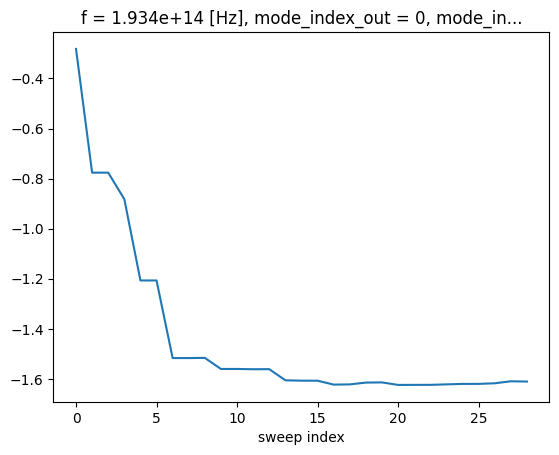

In [16]:
(20 * np.log10(eme_sim_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0).abs)).plot()
plt.show()